# MD Analysis Tomás Frazão

**Last update: 17th October 2022**


some qualitative studies on the MD convergence/sampling quality are performed in this notebook. 
Also a distance is monitored along the simulation.

Concretely:
NOTE: you do not need to load an aligned trajectory as this will be done here.
IMPORTANT: Update SELECTIONS of atoms for fittings according to your system


### How to use this notebook


1. You have to run the cell containing the dependencies imports before starting to run the code. An easy way to have all_loop these dependencies install_looped is to create a conda environment with:

`conda create -n md_analysis -c anaconda -c conda-forge -c ambermd jupyter pytraj mdtraj matplotlib scikit-learn`


### Dependencies of this notebook
* matplotlib (-c conda-forge)
* pytraj (-c ambermd)
* scikit-learn (-c anaconda)
* mdtraj

In [1]:
%matplotlib inline
import pandas as pd
import pytraj as pt
import numpy as np
import math
import matplotlib.pyplot as plt
# we will also use mdtraj
import mdtraj as md
from mdtraj.testing import get_fn
#
from sklearn.decomposition import PCA
import time

import matplotlib.font_manager 
from matplotlib import rc

In [2]:
from matplotlib import font_manager

font_dirs = ['/home/tomas/Downloads']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Arial'

In [3]:
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

## Concept of convergence
"From our point of view and for our scope, a MD trajectory is considered converged when a full exploration of the conformational space is achieved. In particular, a stable conformation or a pull of relative stable conformations visited for a statistically consistent number of times is considered a convergence indicator."

"From this statistical point of view **is not possible to describe if a simulation is absolutely converged** [1]. However, there are several methods in the literature that trough **qualitative and visual analyses** can quickly suggest that the simulation has not run enough and can help **to achieve a good sampling quality**."

## 0. Selection of atoms object of study
Before starting the convergence analyses, the first thing is to define which part of the system will be object of study. 

Typically, very flexible parts such as terminal residues are avoided, and representative atoms of the backbone like alpha carbons are selected.

#### 0.1 Load the trajectory and topology files
Different possibilities are given (some commented) depending on the format of the trajectory files.
Possibilities if the MDs are loaded with pytraj:(basically amber formats)

http://amber-md.github.io/pytraj/latest/read_and_write.html

If the MDs are loaded with mdtraj, we have more possibilities, including xtc (gromacs) +pdb for topology, or a pdb traj.
http://mdtraj.org/1.6.2/load_functions.html#the-trajectory-object

We indicate also the length of the trajectory in ns only for correct axis labels in plots.

In [4]:
TRAJECTORY_I = 'I_both/I_traj.dcd'
TOPOLOGY_I = 'I_both/sys-fad-nowat.prmtop'

TRAJECTORY_II = 'II_both/II_traj.dcd'  
TOPOLOGY_II = 'II_both/AsP2Ox-Closed-C2_autoprep_validated_mini_nowat.prmtop'

TRAJECTORY_IV = 'IV_both/IV_traj.dcd' #it's actually system III without glucose (open glc)
TOPOLOGY_IV = 'IV_both/sys-minus-glc-fad-nowat.prmtop'


TRAJECTORY_LENGTH = 600 #Length of the trajectory in ns (for correct axis labels in plots)

In [5]:
traj_I = pt.iterload(TRAJECTORY_I, TOPOLOGY_I,frame_slice=(0, 62600,10))
traj_Irep = pt.iterload(TRAJECTORY_I, TOPOLOGY_I,frame_slice=(62600, 125200,10))
#traj_I = traj_I[:]

In [6]:
traj_II = pt.iterload(TRAJECTORY_II, TOPOLOGY_II, frame_slice=(0, 62600, 10))
traj_IIrep = pt.iterload(TRAJECTORY_II, TOPOLOGY_II, frame_slice=(62600, 125200, 10))
#traj_II = traj_II[:]

In [7]:
traj_IV = pt.iterload(TRAJECTORY_IV, TOPOLOGY_IV, frame_slice=(0, 62600, 10))
traj_IVrep = pt.iterload(TRAJECTORY_IV, TOPOLOGY_IV, frame_slice=(62600, 125200, 10))
#traj_IV = traj_IV[:]

In [8]:
print(traj_I)
print(traj_II)
print(traj_IV)
print(traj_Irep)
print(traj_IIrep)
print(traj_IVrep)

pytraj.TrajectoryIterator, 6260 frames: 
Size: 1.059908 (GB)
<Topology: 7575 atoms, 508 residues, 2 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 6260 frames: 
Size: 1.063267 (GB)
<Topology: 7599 atoms, 510 residues, 3 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 6260 frames: 
Size: 1.055991 (GB)
<Topology: 7547 atoms, 506 residues, 2 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 6260 frames: 
Size: 1.059908 (GB)
<Topology: 7575 atoms, 508 residues, 2 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 6260 frames: 
Size: 1.063267 (GB)
<Topology: 7599 atoms, 510 residues, 3 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 6260 frames: 
Size: 1.055991 (GB)
<Topology: 7547 atoms, 506 residues, 2 mols, PBC with box type = ortho>
           


#### 0.2 Select the atoms that will be object of the study and align core
We use the notation of pytraj to select the atoms:

https://amber-md.github.io/pytraj/latest/atom_mask_selection.html


In [9]:
# This can be used for initial fitting. Corresponds to core except flexible loop and terminal of MCoA
#ref_SELECTION = '!(:1-6)&!(:285-313)&(@CA)'
ref_SELECTION = ":5-509@CA"

# This corresponds to all Ca (including loop) except flexible terminal. Used for RMSD.
SELECTION = ':5-509@CA'


Now the initial tajectory will be aligned. So no need to load aligned trajectory. 

In [10]:
trajectory_I = pt.align(traj_I, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_II = pt.align(traj_II, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_IV = pt.align(traj_IV, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)

trajectory_Irep = pt.align(traj_Irep, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_IIrep = pt.align(traj_IIrep, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_IVrep = pt.align(traj_IVrep, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)

## 2a. Substrate-loop (A352-CA) to N5 distance

In [11]:
# compute distance between A352-CA and N5
Sloop_I = pt.distance(trajectory_I, ':348@CA :FAD@N5') 
Sloop_II = pt.distance(trajectory_II, ':348@CA :FAD@N5') 
Sloop_IV = pt.distance(trajectory_IV, ':348@CA :FAD@N5') 

Sloop_Irep = pt.distance(trajectory_Irep, ':348@CA :FAD@N5') 
Sloop_IIrep = pt.distance(trajectory_IIrep, ':348@CA :FAD@N5') 
Sloop_IVrep = pt.distance(trajectory_IVrep, ':348@CA :FAD@N5')


print(Sloop_I)
print(Sloop_II)
print(Sloop_IV)
print(Sloop_Irep)
print(Sloop_IIrep)
print(Sloop_IVrep)

[18.43390957 18.68714547 18.84142552 ... 18.43410769 18.79119758
 18.25294223]
[18.36386597 18.26994855 18.43774583 ... 15.66477428 15.52235353
 15.48685098]
[25.29587278 25.36746126 24.30282322 ... 17.9312215  17.90041865
 18.00047339]
[17.76549933 17.97870148 17.73065148 ... 16.82967065 16.86108856
 15.94713117]
[18.88442981 18.85449617 18.77512148 ... 23.87306327 24.22744123
 24.47232968]
[27.02850996 25.40424802 26.30737647 ... 32.15711733 33.31047507
 33.63793162]


In [12]:
MAX_DISTANCE_LOOP1 = math.ceil(Sloop_I.max()) #It can be modified if you want to change the scale of the plot. If xtc.
MIN_DISTANCE_LOOP1 = math.ceil(Sloop_I.min()) #For use in PCA plot. If xtc, as before.

MAX_DISTANCE_LOOP2 = math.ceil(Sloop_II.max()) 
MIN_DISTANCE_LOOP2 = math.ceil(Sloop_II.min())

MAX_DISTANCE_LOOP3 = math.ceil(Sloop_IV.max()) 
MIN_DISTANCE_LOOP3 = math.ceil(Sloop_IV.min())

## 2b. Insertion (G84-CA) to N5 distance

In [13]:
# compute distance between P83-CG and N5
Iloop_I = pt.distance(trajectory_I, ':80@CA :FAD@N5')
Iloop_II = pt.distance(trajectory_II, ':80@CA :FAD@N5') 
Iloop_IV = pt.distance(trajectory_IV, ':80@CA :FAD@N5') 
Iloop_Irep = pt.distance(trajectory_Irep, ':80@CA :FAD@N5')
Iloop_IIrep = pt.distance(trajectory_IIrep, ':80@CA :FAD@N5') 
Iloop_IVrep = pt.distance(trajectory_IVrep, ':80@CA :FAD@N5') 


print(Iloop_I)
print(Iloop_II)
print(Iloop_IV)
print(Iloop_Irep)
print(Iloop_IIrep)
print(Iloop_IVrep)

[19.65730511 20.50236304 20.25818079 ... 20.57226412 21.13305436
 20.38655647]
[18.33611131 18.03335676 18.52164562 ... 19.18253335 18.31557054
 18.8799762 ]
[30.98495072 29.8824819  27.6779546  ... 20.67146466 20.64504436
 21.44545767]
[20.07009882 19.18787663 19.60714483 ... 18.49491715 19.40310215
 18.0307473 ]
[18.83150736 19.07757932 17.79120422 ... 18.63381604 19.09123442
 19.1900119 ]
[29.50198012 30.06525686 28.70958524 ... 18.36397972 18.98564453
 17.18629329]


In [14]:
MAX_DISTANCE_INSERTION = math.ceil(Iloop_I.max()) #It can be modified if you want to change the scale of the plot. If xtc.
MIN_DISTANCE_INSERTION = math.ceil(Iloop_I.min()) #For use in PCA plot. If xtc, as before.

# Histograms substrate loop

# 1. Native

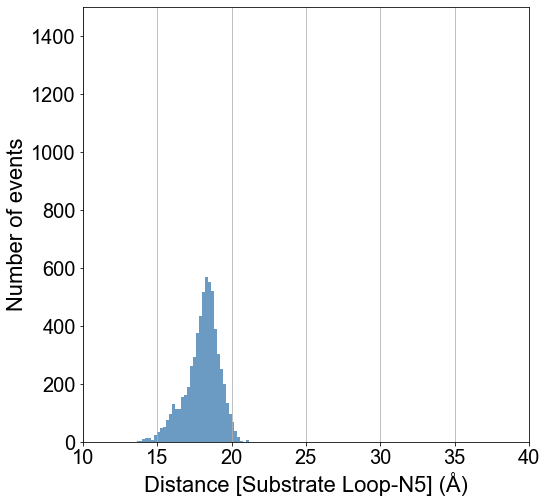

In [15]:
plt.figure(figsize=(8,8))
plt.hist(Sloop_I, bins=40, facecolor='steelblue', alpha=0.8)
plt.xlabel("Distance [Substrate Loop-N5] (Å)", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.ylim(0,1500)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(['I (Native)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 2)
#plt.show()
plt.savefig("./hist_Sloop_I.png", bbox_inches='tight', dpi=600)

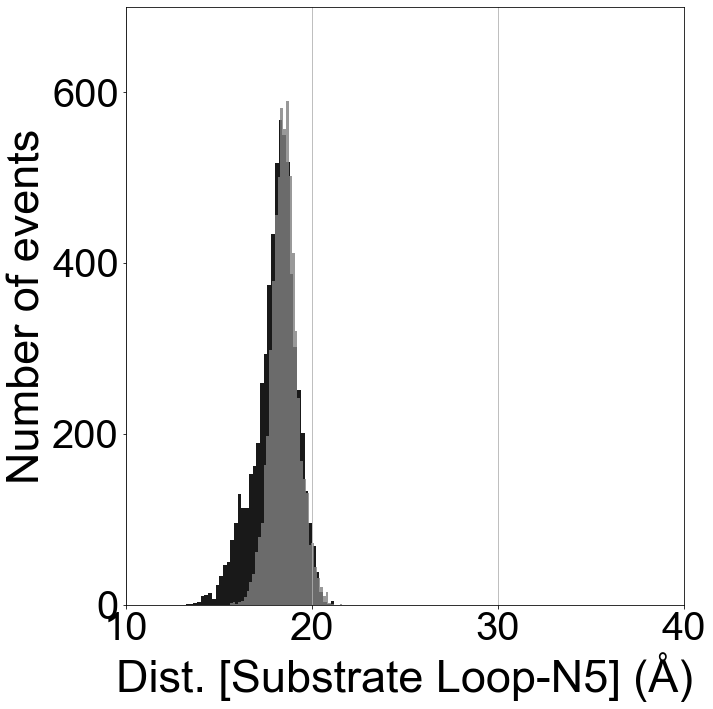

In [45]:
plt.rcParams['font.size']=45
plt.figure(figsize=(10,11))
plt.hist(Sloop_I, bins=40, facecolor='black', alpha=0.9)
plt.hist(Sloop_Irep, bins=40, facecolor='grey', alpha=0.8)
plt.xlabel("Dist. [Substrate Loop-N5] (Å)")
plt.ylabel("Number of events")
plt.ylim(0,700)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.legend(['I (Native)','I rep (Native)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 1)
#plt.show()
plt.savefig("./hist_Sloop_I_withREP.png", bbox_inches='tight', dpi=600)

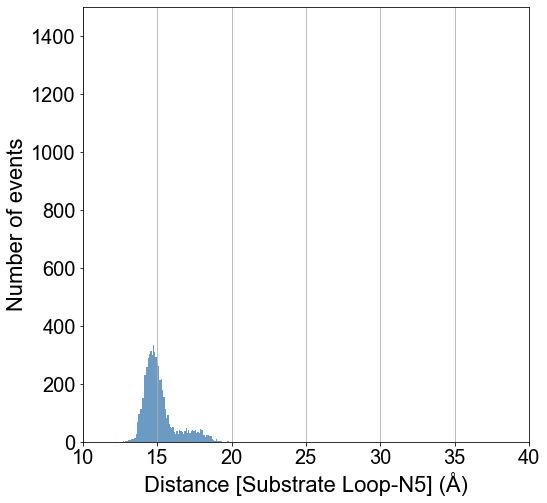

In [17]:
plt.figure(figsize=(8,8))
plt.hist(Sloop_II, bins=100, facecolor='steelblue', alpha=0.8)
plt.xlabel("Distance [Substrate Loop-N5] (Å)", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.ylim(0,1500)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(['II (Glc Semi-Open)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 2)
#plt.show()
plt.savefig("./hist_Sloop_II.png", bbox_inches='tight', dpi=600)

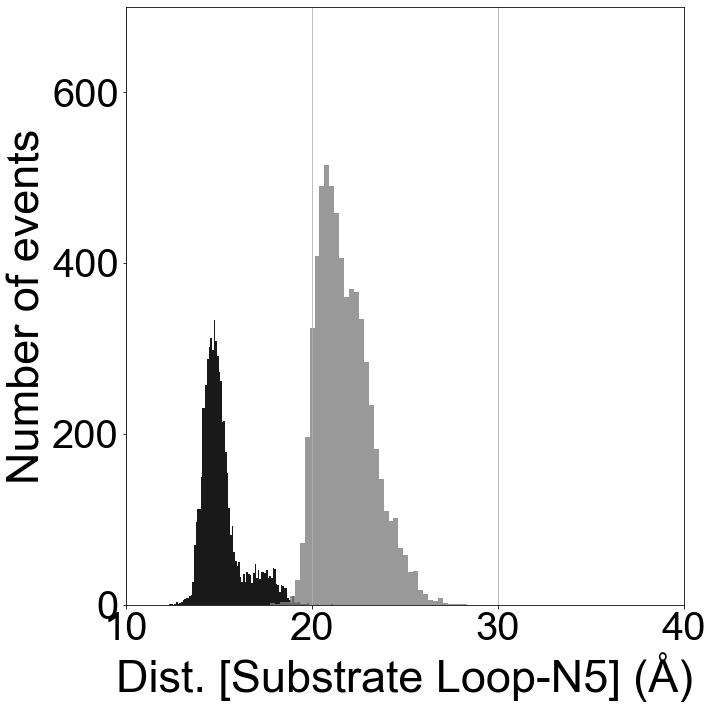

In [50]:
plt.rcParams['font.size']=45
plt.figure(figsize=(10,11))
plt.hist(Sloop_II, bins=100, facecolor='black', alpha=0.9)
plt.hist(Sloop_IIrep, bins=40, facecolor='grey', alpha=0.8)
plt.xlabel("Dist. [Substrate Loop-N5] (Å)")
plt.ylabel("Number of events")
plt.ylim(0,700)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.legend(['II (Glc Semi-Open)', 'II rep (Glc Semi-Open)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 1)
#plt.show()
plt.savefig("./hist_Sloop_II_withREP.png", bbox_inches='tight', dpi=600)

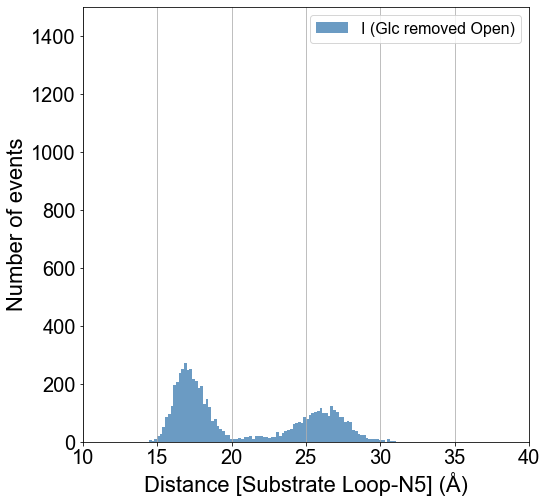

In [19]:
plt.figure(figsize=(8,8))
plt.hist(Sloop_IV, bins=100, facecolor='steelblue', alpha=0.8)
plt.xlabel("Distance [Substrate Loop-N5] (Å)", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.ylim(0,1500)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['I (Glc removed Open)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 2)
#plt.show()
plt.savefig("./hist_Sloop_IV.png", bbox_inches='tight', dpi=600)

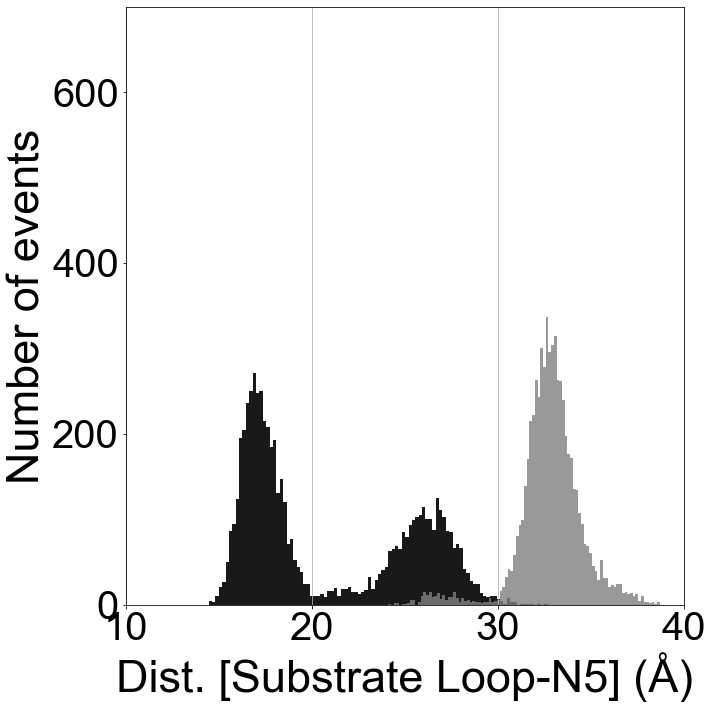

In [49]:
plt.rcParams['font.size']=45
plt.figure(figsize=(10,11))
plt.hist(Sloop_IV, bins=100, facecolor='black', alpha=0.9)
plt.hist(Sloop_IVrep, bins=100, facecolor='grey', alpha=0.8)
plt.xlabel("Dist. [Substrate Loop-N5] (Å)")
plt.ylabel("Number of events")
plt.ylim(0,700)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.legend(['III* (Glc removed Open)', 'III* rep (Glc removed Open)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 1)
#plt.show()
plt.savefig("./hist_Sloop_IVwithREP.png", bbox_inches='tight', dpi=600)

# Histograms insertion-1

# 1. Native

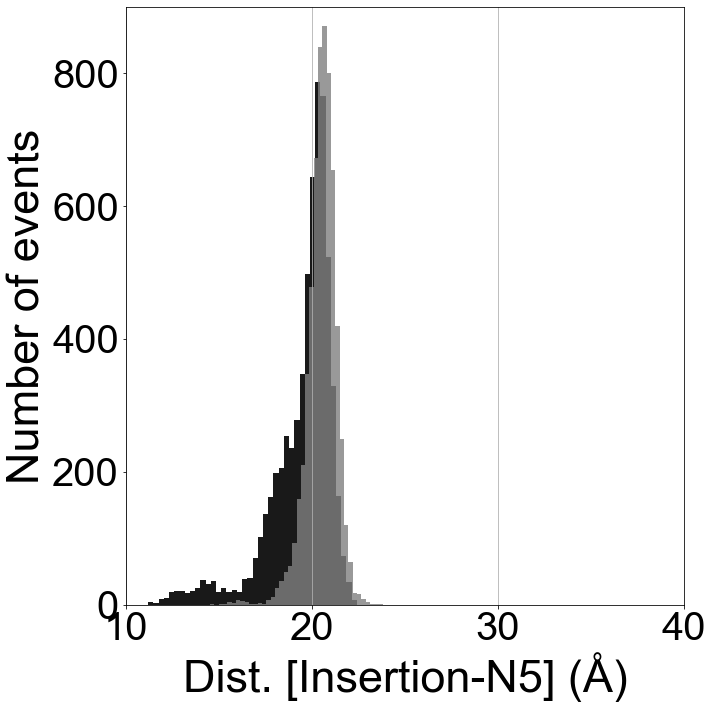

In [48]:
plt.rcParams['font.size']=45
plt.figure(figsize=(10,11))
plt.hist(Iloop_I, bins=40, facecolor='black', alpha=0.9)
plt.hist(Iloop_Irep, bins=40, facecolor='grey', alpha=0.8)
plt.xlabel("Dist. [Insertion-N5] (Å)")
plt.ylabel("Number of events")
plt.ylim(0,900)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.legend(['I (Native)','I rep (Native)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 1)
#plt.show()
plt.savefig("./hist_Iloop_I_withREP.png", bbox_inches='tight', dpi=600)

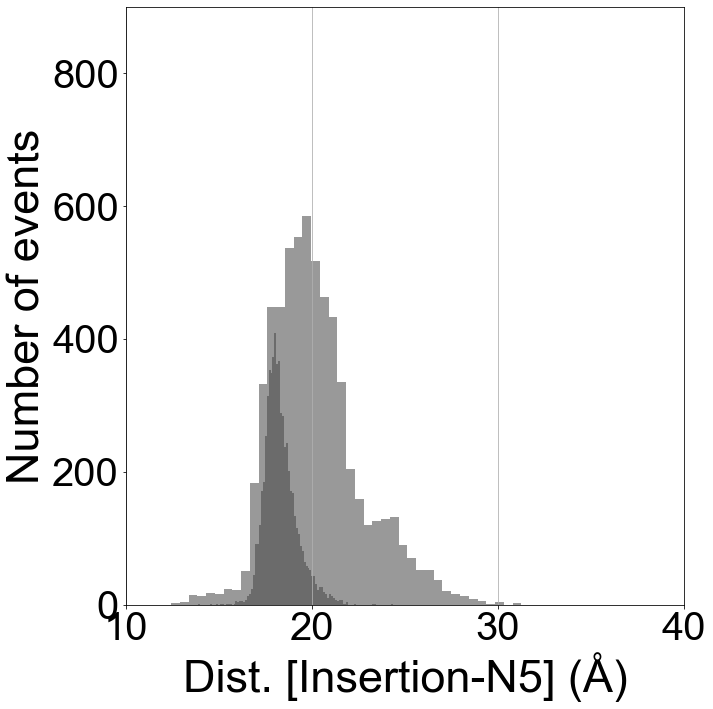

In [15]:
plt.rcParams['font.size']=45
plt.figure(figsize=(10,11))
plt.hist(Iloop_II, bins=100, facecolor='black', alpha=0.9)
plt.hist(Iloop_IIrep, bins=40, facecolor='grey', alpha=0.8)
plt.xlabel("Dist. [Insertion-N5] (Å)")
plt.ylabel("Number of events")
plt.ylim(0,900)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.legend(['II (Glc Semi-Open)', 'II rep (Glc Semi-Open)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 1)
#plt.show()
plt.savefig("./hist_Iloop_II_withREP.png", bbox_inches='tight', dpi=600)

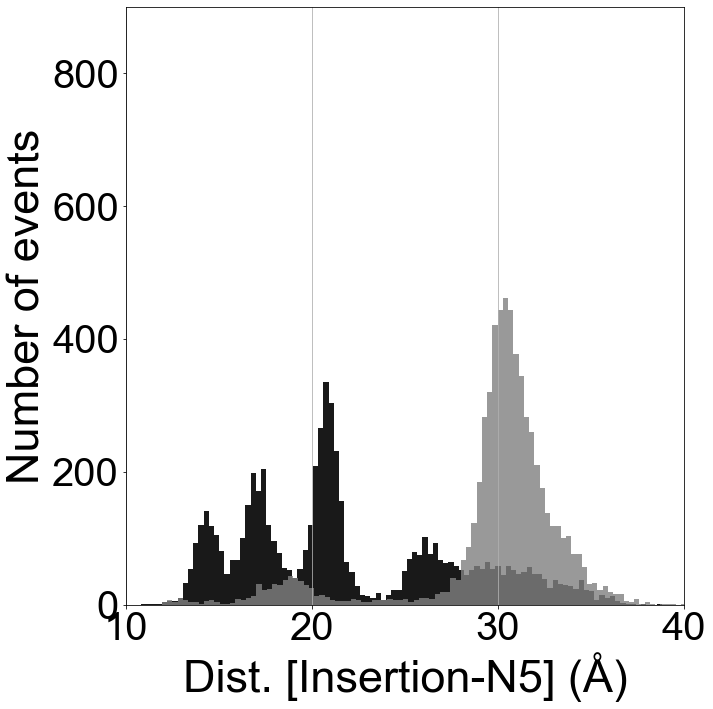

In [16]:
plt.rcParams['font.size']=45
plt.figure(figsize=(10,11))
plt.hist(Iloop_IV, bins=100, facecolor='black', alpha=0.9)
plt.hist(Iloop_IVrep, bins=100, facecolor='grey', alpha=0.8)
plt.xlabel("Dist. [Insertion-N5] (Å)")
plt.ylabel("Number of events")
plt.ylim(0,900)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.legend(['III* (Glc removed Open)', 'III* rep (Glc removed Open)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 1)
#plt.show()
plt.savefig("./hist_Iloop_IVwithREP.png", bbox_inches='tight', dpi=600)